# Hands-on Tutorial
## Domain-Driven LLM Development: Insights into RAG and Fine-Tuning Practices
### Lab 1.2: Advanced RAG
#### Summary: 
This lab focused on enhancing the Retrieval-Augmented Generation (RAG) process by implementing and comparing four advanced optimizations against a baseline Naive RAG approach. The optimizations were:

- Sentence Chunking
- Hypothetical Question Generation
- Query Decomposition
- Hypothetical Question + Query Decomposition


#### Load the naive RAG performace as baseline

Uncomment the following lines if the packages are not installed 

In [ ]:
#!pip install pandas matplotlib
#!pip install -U langchain-community
#!pip install pypdf

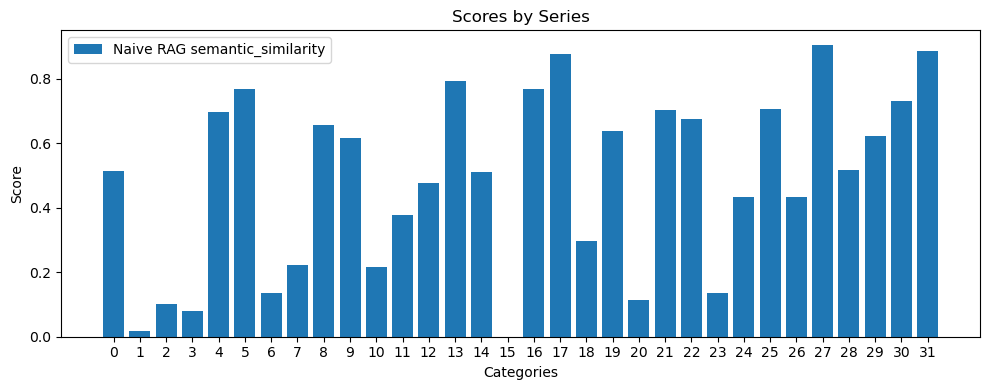

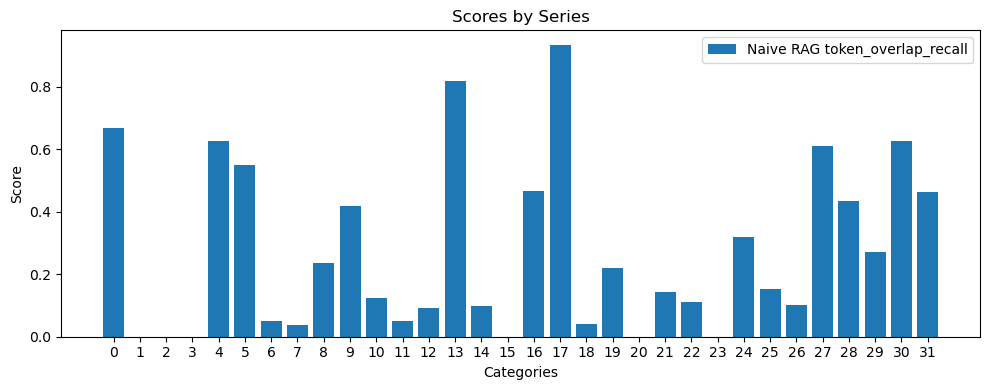

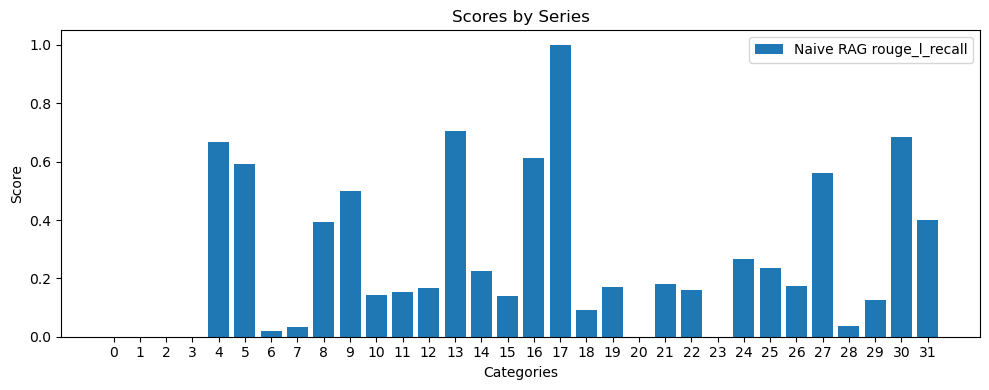

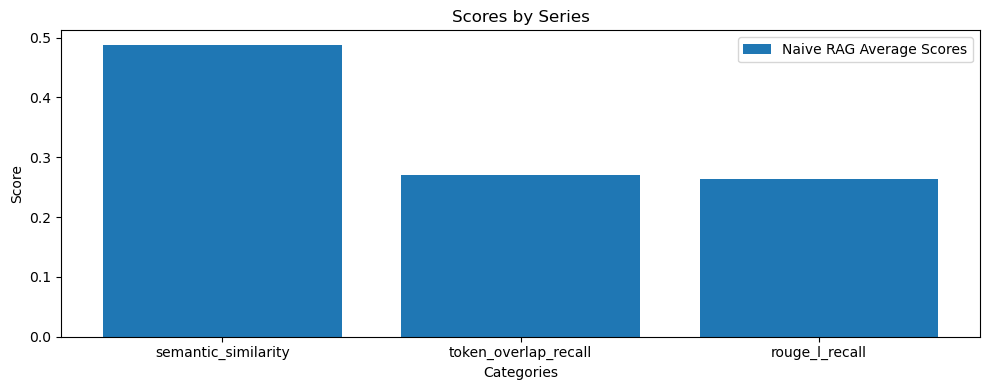

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_barchart(series_names, series_data, x_labels):
    """
    Plot bar charts for multiple series with x-axis labels and legends.

    :param series_names: List of names for each data series (used as legends).
    :param series_data: List of lists, where each inner list is a series of double numbers.
    :param x_labels: List of labels for the x-axis.
    """
    plt.figure(figsize=(10, 4))
    
    # Number of series to plot
    num_series = len(series_data)
    
    # Bar width depends on the number of series
    bar_width = 0.8 / num_series
    
    # X-axis positions for the bars
    x = range(len(x_labels))
    
    # Plot each series
    for i, (name, data) in enumerate(zip(series_names, series_data)):
        plt.bar([pos + i * bar_width for pos in x], data, bar_width, label=name)
    
    # Add labels, title, and legend
    plt.xlabel('Categories')
    plt.ylabel('Score')
    plt.title('Scores by Series')
    plt.xticks([pos + bar_width * (num_series / 2 - 0.5) for pos in x], x_labels)
    plt.legend()
    
    # Display the chart
    plt.tight_layout()
    plt.show()

file_path = '../lab-data/naive_rag_result.csv'
df = pd.read_csv(file_path)
metrics = df.columns[-3:]

# Prepare the data
series_names = [f"Naive RAG {name}" for name in metrics.tolist()]
series_data = [df[metric].tolist() for metric in metrics]

# Plot individual series bar charts
for i in range(3):
    plot_barchart([series_names[i]], [series_data[i]], list(range(len(series_data[i]))))

# Calculate the average for each metric
average_scores = [sum(data) / len(data) for data in series_data]

# Plot the average scores bar chart
plot_barchart(['Naive RAG Average Scores'], [average_scores], metrics.tolist())


In [2]:
#import fitz
from langchain_community.document_loaders import PyPDFLoader

In [3]:
import boto3
import json
import re

def generate(prompt):
    # Create the request payload
    payload = {
        "prompt": prompt,
        "temperature": 0,  # Adjust the randomness of the output
        "max_gen_len": 128
    }

    # Initialize the Bedrock runtime client
    client = boto3.client('bedrock-runtime', region_name='us-west-2')

    # Invoke the model
    response = client.invoke_model(
        modelId='meta.llama3-8b-instruct-v1:0',
        contentType='application/json',
        accept='application/json',
        body=json.dumps(payload)
    )
    
    byte_response = response['body'].read()
    json_string = byte_response.decode('utf-8')

    # Get the chat response
    response_body = json.loads(json_string)
    chat_response = response_body.get('generation')

    return chat_response

In [4]:
def generate_hypothetical_questions(question):
    prompt = f"""
<s>[INST] <<SYS>>
Given the following text, generate a list of hypothetical questions that could be asked about the content, each in a single line. The questions should focus on key details, definitions, and information present in the text.
<</SYS>>
<text>
{question}
</text>
<questions>
[/INST]
"""
    cleaned_response = re.sub(r'</?[^>]+>', '', generate(prompt))
    return [question for question in cleaned_response.split('\n') if len(question) > 10]

questions = generate_hypothetical_questions("""Exhibit 10.24 \n \n[***]\nCertain confidential information contained in this document, marked by brackets, has been omitted and filed separately with the\nSecurities and Exchange Commission pursuant to Rule 24b-2 of the Securities Exchange Act of 1934, as amended.\n \nEXECUTION VERSION\n \nSTRATEGIC ALLIANCE AGREEMENT\n \nTHIS STRATEGIC ALLIANCE AGREEMENT (“Agreement”) is made and entered into as of November 6, 2016 (the “Effective Date”) by\nand between Dialog Semiconductor (UK) Ltd., a corporation organized under the laws of England and Wales, having its principal office at 100\nLongwater Avenue, Green Park, Reading, RG2 6GP, United Kingdom (“DIALOG”) and Energous Corporation, a Delaware corporation, having its\nprincipal office at 3590 North First Street, Suite 210, San Jose, CA 95134 (“ENERGOUS”).\n \nWHEREAS DIALOG is a supplier of mixed-signal semiconductor products;\n \nWHEREAS ENERGOUS is a supplier of uncoupled wirefree charging systems, including antennas, semiconductors, firmware, software,\nalgorithms, and sensors;""")

print(questions)

['What is the purpose of the brackets in the document?', 'What is the date of the Strategic Alliance Agreement?', 'What is the name of the corporation that is a supplier of mixed-signal semiconductor products?', 'What is the name of the corporation that is a supplier of uncoupled wirefree charging systems?', "What is the location of Dialog Semiconductor (UK) Ltd.'s principal office?", "What is the location of Energous Corporation's principal office?", 'What is the purpose of the Strategic Alliance Agreement?', 'What are the key products or services provided by Dialog']


In [5]:
# Function to extract text using langchain
def extract_text_from_pdf_loader(pdf_path):
    text = ""
    loader = PyPDFLoader(pdf_path)
    document = loader.lazy_load()
    for doc in document:
        text += doc.page_content
    return text

In [6]:
# Extract the text from the PDF using langchain
pdf_text_pdfldr = extract_text_from_pdf_loader("../lab-data/ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALLIANCE AGREEMENT.PDF").replace('\xa0', ' ')
pdf_text_pdfldr  # Displaying to get an overview of the content

'Exhibit 10.24 \n \n[***] Certain confidential information contained in this document, marked by brackets, has been omitted and filed separately with the\nSecurities and Exchange Commission pursuant to Rule 24b-2 of the Securities Exchange Act of 1934, as amended.\n \nEXECUTION VERSION\n \nSTRATEGIC ALLIANCE AGREEMENT\n \nTHIS STRATEGIC ALLIANCE AGREEMENT (“Agreement”) is made and entered into as of November 6, 2016 (the “ Effective Date”) by\nand between Dialog Semiconductor (UK) Ltd., a corporation organized under the laws of England and Wales, having its principal office at 100\nLongwater Avenue, Green Park, Reading, RG2 6GP, United Kingdom (“DIALOG”) and Energous Corporation, a Delaware corporation, having its\nprincipal office at 3590 North First Street, Suite 210, San Jose, CA 95134 (“ENERGOUS”).\n \nWHEREAS DIALOG is a supplier of mixed-signal semiconductor products;\n \nWHEREAS ENERGOUS is a supplier of uncoupled wirefree charging systems, including antennas, semiconductors, fi

#### Sentence Chunking + Sentence Window Retrieval Optimization

Purpose: Improve the retrieval accuracy by breaking down documents into smaller, more focused chunks (typically sentences).

Implementation: Documents are split into sentences, and each sentence is embedded separately. During the retrieval phase, queries are matched against these sentence-level embeddings, and then retrieve the surrounding sentences (similar idea as sliding window) to maintain the context cohesiveness.

Outcome: This technique generally improves the precision of retrieved content, ensuring that the most relevant parts of the documents are used in generation.

In [ ]:
def sentence_chunker(text):
    """
    Chunk text into sentences.
    """
    return [f"{sentence}." for sentence in text.split(".")]

sentences = sentence_chunker(pdf_text_pdfldr)
sentences

In [ ]:
def sentence_window_builder(sentences, window_size):
    def sentence_length(sentence):
        """Helper function to calculate the length of a sentence."""
        return len(sentence)

    windows = []
    window_left_index = []
    window_right_index = []

    for i in range(len(sentences)):
        current_sentence = sentences[i]
        current_length = sentence_length(current_sentence)
        left_context = []
        right_context = []
        total_length = sentence_length(current_sentence)
        
        # Expand left context
        left_index = i - 1
        while left_index >= 0 and total_length + sentence_length(sentences[left_index]) - current_length // 2 <= window_size // 2:
            left_context.insert(0, sentences[left_index])
            total_length += sentence_length(sentences[left_index])
            left_index -= 1
        
        # Expand right context
        right_index = i + 1
        while right_index < len(sentences) and total_length + sentence_length(sentences[right_index]) - current_length // 2 <= window_size:
            right_context.append(sentences[right_index])
            total_length += sentence_length(sentences[right_index])
            right_index += 1
        
        # Build the window for the current sentence
        window = left_context + [current_sentence] + right_context
        windows.append(' '.join(window))
        window_left_index.append(left_index + 1)
        window_right_index.append(right_index - 1)
    
    return windows, window_left_index, window_right_index

window_size = 1024
windows, window_left_index, window_right_index = sentence_window_builder(sentences, window_size)
for i, w in enumerate(windows):
    print(f"Window {i+1}: {w}")
    print(f"Window Range: [{window_left_index[i]}: {window_right_index[i]}]")

In [9]:
from pyepsilla import vectordb
## connect to vectordb
db = vectordb.Client(
  host='localhost',
  port='8888'
)

[INFO] Connected to localhost:8888 successfully.


In [10]:
db.unload_db("kdd_lab1_advanced_rag")
db.load_db(db_name="kdd_lab1_advanced_rag", db_path="/tmp/kdd_lab1_advanced_rag")

(200,
 {'statusCode': 200,
  'message': 'Load/Create kdd_lab1_advanced_rag successfully.'})

In [11]:
db.use_db(db_name="kdd_lab1_advanced_rag")
db.drop_table("SentenceWindow")
db.create_table(
  table_name="SentenceWindow",
  table_fields=[
    {"name": "ID", "dataType": "INT", "primaryKey": True},
    {"name": "Sentence", "dataType": "STRING"},
    {"name": "Left", "dataType": "INT"},
    {"name": "Right", "dataType": "INT"},
    {"name": "Embedding", "dataType": "VECTOR_FLOAT", "dimensions": 512}
  ]
)

(200, {'statusCode': 200, 'message': 'Create SentenceWindow successfully.'})

In [12]:
# Initialize the Bedrock client
client = boto3.client('bedrock-runtime', region_name='us-west-2')
# Function to embed text
def embed_text(input_text):
    # Create the request payload
    payload = {
        "inputText": input_text,
        "dimensions": 512,  # Specify the desired dimension size
        "normalize": True  # Whether to normalize the output embeddings
    }

    # Invoke the model
    response = client.invoke_model(
        body=json.dumps(payload),
        modelId='amazon.titan-embed-text-v2:0',  # Specify the Titan embedding model
        accept='application/json',
        contentType='application/json'
    )

    # Get the embedding result
    response_body = json.loads(response['body'].read())
    embedding = response_body.get('embedding')
    return embedding

# Print the embedding
print(embed_text(sentences[0]))

[-0.08786613494157791, 0.02316470816731453, 0.05391785502433777, 0.01677444390952587, 0.043733369559049606, -0.006440188270062208, 0.029754668474197388, 0.029754668474197388, 0.025061817839741707, -0.02396349050104618, 0.004817659966647625, 0.06669837981462479, -0.006015834864228964, -0.01827216148376465, -0.00188462866935879, -0.023464251309633255, 0.034147974103689194, 0.025760753080248833, 0.05311907082796097, 0.022865165024995804, 0.028556494042277336, 0.0361449308693409, 0.0016474899603053927, -0.015875812619924545, 0.008337297476828098, -0.01697413995862007, 0.04612971842288971, -0.04792698100209236, 0.006689807865768671, -0.11262840777635574, 0.023863643407821655, 0.058710552752017975, -0.029355276376008987, 0.04473184794187546, 0.04612971842288971, 0.162152960896492, 0.013179919682443142, -0.017273683100938797, 0.004617964383214712, 0.0036194855347275734, 0.06829594820737839, -0.036744020879268646, -0.0004461952194105834, -0.005017356015741825, -0.043733369559049606, -0.0190709

In [ ]:
records = [
    {
        "ID": index,
        "Sentence": sentences[index],
        "Left": window_left_index[index],
        "Right": window_right_index[index],
        "Embedding": embed_text(sentences[index])
    }
    for index in range(len(sentences))
]
records[:2]

In [14]:
db.insert("SentenceWindow", records)

(200,
 {'message': 'Insert data to SentenceWindow successfully.',
  'result': {'inserted': 526, 'skipped': 0},
  'statusCode': 200})

In [ ]:
def sentence_window_retriever(table_name, question, top_k):
    code, resp = db.query(
        table_name=table_name,
        query_field="Embedding",
        query_vector=embed_text(question),
        limit=top_k
    )
    id_list = []
    for item in resp["result"]:
        for id in range(item["Left"], item["Right"] + 1):
            if id not in id_list:  # Check if the ID is already in the list
                id_list.append(id)  # Append the ID if it's not a duplicate

    code, resp = db.get(
        table_name=table_name,
        response_fields=["Sentence"],
        primary_keys=id_list
    )
    return id_list, [item["Sentence"] for item in resp["result"]]
sentence_window_retriever("SentenceWindow", "What's the agreement date?", 5)

In [16]:
import re
def sentence_window_rag(table_name, question):
    ids, sentences = sentence_window_retriever(table_name, question, 5)
    docs_str = "".join(sentences)
    prompt = f"""
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.

Your answer should be grounded by the information provided in the documents below.
Don't make up answers.
Don't explain your thought process.
Directly answer the question in concise way.

<documents>
{docs_str}
</documents>
<</SYS>>

{question}[/INST]
"""
    cleaned_response = re.sub(r'</?[^>]+>|\[/?(INST|SYS)\]', '', generate(prompt))
    return prompt, cleaned_response

data_augmented_prompt, answer = sentence_window_rag("SentenceWindow", "What's the agreement date?")

print(answer)

 >
The agreement date is November 6, 2016.
 ></s


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '../lab-data/ENERGOUSCORP_qa.csv'
df = pd.read_csv(file_path)

# Assuming the CSV has 'Question' and 'Answer' columns
questions = df['question'].tolist()
answers = df['answer'].tolist()

questions, answers

In [ ]:
data_augmented_prompts = []
generated_answers = []
for question in questions:
    data_augmented_prompt, generated_answer = sentence_window_rag("SentenceWindow", question)
    data_augmented_prompts.append(data_augmented_prompt)
    generated_answers.append(generated_answer)

generated_answers

In [19]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from continuous_eval.metrics.generation.text import DeterministicAnswerCorrectness
from sentence_transformers import SentenceTransformer, util

evaluation_results = []
for i in range(len(questions)):
    print(i,end='|')
    ground_truth_embedding = embed_text(answers[i])
    answer_embedding = embed_text(generated_answers[i])
    cosine_similarity = util.cos_sim(ground_truth_embedding, answer_embedding)[0][0].item()
    
    datum = {
        "answer": generated_answers[i],
        "ground_truth_answers": [
            answers[i]
        ]
    }
    metric = DeterministicAnswerCorrectness()
    eval_result = metric(**datum)
    evaluation_results.append({
        "question": data_augmented_prompts[i],
        "ref_answer": answers[i],
        "response": generated_answers[i],
        "semantic_similarity": cosine_similarity,
        "token_overlap_recall": eval_result["token_overlap_recall"],
        "rouge_l_recall": eval_result["rouge_l_recall"]
    })

evaluation_results

In [21]:
import csv

# Specify the file name
csv_file = '../lab-data/sentence_window_rag_result.csv'

# Write the data to a CSV file
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=evaluation_results[0].keys())
    writer.writeheader()
    writer.writerows(evaluation_results)

csv_file

'../lab-data/sentence_window_rag_result.csv'

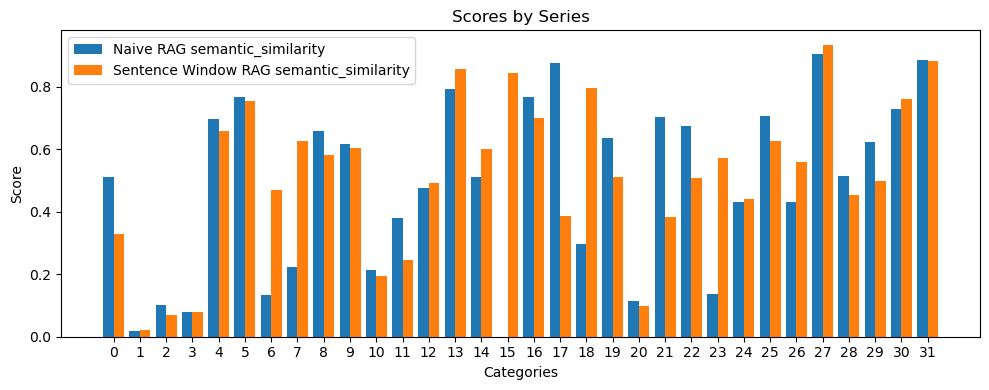

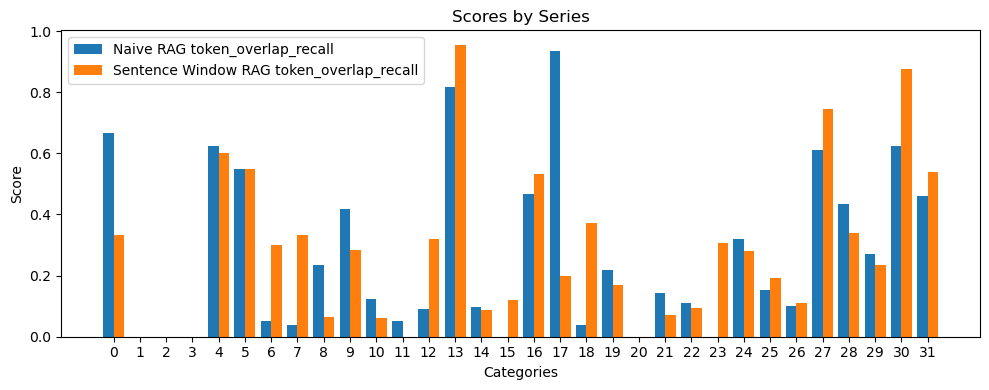

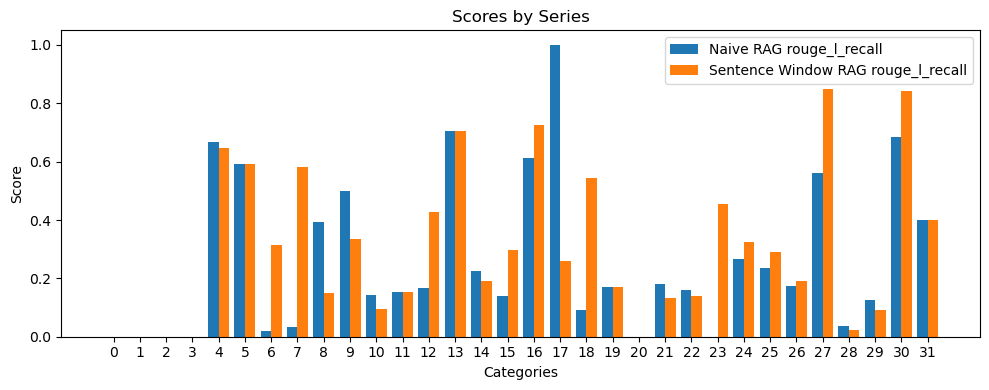

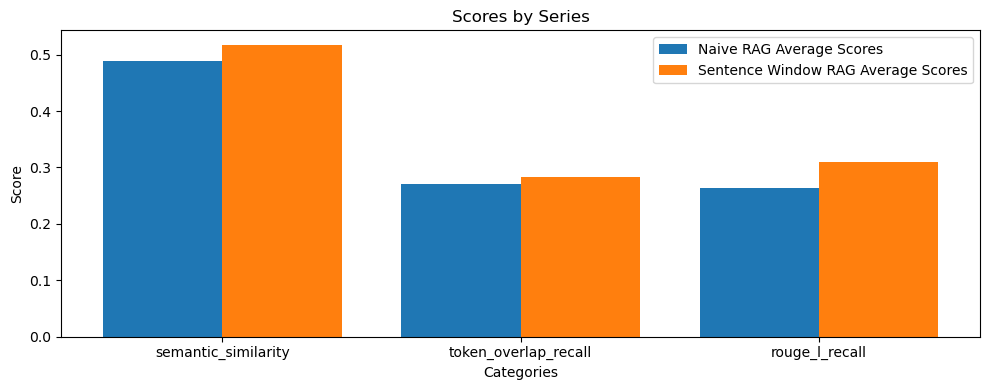

In [22]:
file_path = '../lab-data/sentence_window_rag_result.csv'
df = pd.read_csv(file_path)
metrics = df.columns[-3:]

# Prepare the data
sentence_window_series_names = [f"Sentence Window RAG {name}" for name in metrics.tolist()]
sentence_window_series_data = [df[metric].tolist() for metric in metrics]

# Plot individual series bar charts
for i in range(3):
    plot_barchart(
        [series_names[i], sentence_window_series_names[i]],
        [series_data[i], sentence_window_series_data[i]],
        list(range(len(series_data[i])))
    )

# Calculate the average for each metric
sentence_window_average_scores = [sum(data) / len(data) for data in sentence_window_series_data]

# Plot the average scores bar chart
plot_barchart(['Naive RAG Average Scores', 'Sentence Window RAG Average Scores'], [average_scores, sentence_window_average_scores], metrics.tolist())

#### Hypothetical Questions Optimization

Purpose: Enhance retrieval relevance by transforming documents into hypothetical questions that are more likely to match user question semantically.

Implementation: Use LLM to generate a few hypothetical questions from each chunk. Embed the questions in vector database for retrieval, and when rendering the final prompt, use the corresponding original chunks instead of the hypothetical questions as knowledge.

Outcome: This approach increases the specificity and relevance of the retrieved content, improving the context provided to the language model.

In [23]:
import boto3
import json
import re

def generate(prompt):
    # Create the request payload
    payload = {
        "prompt": prompt,
        "temperature": 0,  # Adjust the randomness of the output
        "max_gen_len": 128
    }

    # Initialize the Bedrock runtime client
    client = boto3.client('bedrock-runtime', region_name='us-west-2')

    # Invoke the model
    response = client.invoke_model(
        modelId='meta.llama3-8b-instruct-v1:0',
        contentType='application/json',
        accept='application/json',
        body=json.dumps(payload)
    )
    
    byte_response = response['body'].read()
    json_string = byte_response.decode('utf-8')

    # Get the chat response
    response_body = json.loads(json_string)
    chat_response = response_body.get('generation')

    return chat_response


#def generate_hypothetical_questions(question):
#    prompt = f"""
#<s>[INST] <<SYS>>
#Given the following text, generate a list of hypothetical questions that could be asked about the content, each in a single line. The questions should focus on key details, definitions, and information present in the text.
#<</SYS>>
#<text>
#{question}
#</text>
#<questions>
#[/INST]
#"""
#    cleaned_response = re.sub(r'</?[^>]+>', '', generate(prompt))
#    return [question for question in cleaned_response.split('\n') if len(question) > 10]
#
#questions = generate_hypothetical_questions("""Exhibit 10.24 \n \n[***]\nCertain confidential information contained in this document, marked by brackets, has been omitted and filed separately with the\nSecurities and Exchange Commission pursuant to Rule 24b-2 of the Securities Exchange Act of 1934, as amended.\n \nEXECUTION VERSION\n \nSTRATEGIC ALLIANCE AGREEMENT\n \nTHIS STRATEGIC ALLIANCE AGREEMENT (“Agreement”) is made and entered into as of November 6, 2016 (the “Effective Date”) by\nand between Dialog Semiconductor (UK) Ltd., a corporation organized under the laws of England and Wales, having its principal office at 100\nLongwater Avenue, Green Park, Reading, RG2 6GP, United Kingdom (“DIALOG”) and Energous Corporation, a Delaware corporation, having its\nprincipal office at 3590 North First Street, Suite 210, San Jose, CA 95134 (“ENERGOUS”).\n \nWHEREAS DIALOG is a supplier of mixed-signal semiconductor products;\n \nWHEREAS ENERGOUS is a supplier of uncoupled wirefree charging systems, including antennas, semiconductors, firmware, software,\nalgorithms, and sensors;""")

#print(questions)

In [25]:
def chunk_text(text, chunk_size, overlap):
    """
    Chunk text into smaller segments with a specified chunk size and overlap.

    Parameters:
    - text (str): The text to be chunked.
    - chunk_size (int): The size of each chunk.
    - overlap (int): The number of characters that overlap between chunks.

    Returns:
    - List[str]: A list of text chunks.
    """
    if chunk_size <= overlap:
        raise ValueError("Chunk size must be greater than overlap")

    chunks = []
    start = 0
    end = chunk_size

    while start < len(text):
        chunk = text[start:end]
        chunks.append(chunk)
        start += chunk_size - overlap
        end = start + chunk_size

    return chunks

chunks = chunk_text(pdf_text_pdfldr, 1024, 256)
print(len(chunks))
chunks[:2]

107


['Exhibit 10.24 \n \n[***] Certain confidential information contained in this document, marked by brackets, has been omitted and filed separately with the\nSecurities and Exchange Commission pursuant to Rule 24b-2 of the Securities Exchange Act of 1934, as amended.\n \nEXECUTION VERSION\n \nSTRATEGIC ALLIANCE AGREEMENT\n \nTHIS STRATEGIC ALLIANCE AGREEMENT (“Agreement”) is made and entered into as of November 6, 2016 (the “ Effective Date”) by\nand between Dialog Semiconductor (UK) Ltd., a corporation organized under the laws of England and Wales, having its principal office at 100\nLongwater Avenue, Green Park, Reading, RG2 6GP, United Kingdom (“DIALOG”) and Energous Corporation, a Delaware corporation, having its\nprincipal office at 3590 North First Street, Suite 210, San Jose, CA 95134 (“ENERGOUS”).\n \nWHEREAS DIALOG is a supplier of mixed-signal semiconductor products;\n \nWHEREAS ENERGOUS is a supplier of uncoupled wirefree charging systems, including antennas, semiconductors, f

In [26]:
db.drop_table("HypotheticalQuestions")
db.create_table(
  table_name="HypotheticalQuestions",
  table_fields=[
    {"name": "Question", "dataType": "STRING"},
    {"name": "ChunkID", "dataType": "INT"},
    {"name": "Embedding", "dataType": "VECTOR_FLOAT", "dimensions": 512}
  ]
)

(200,
 {'statusCode': 200, 'message': 'Create HypotheticalQuestions successfully.'})

In [27]:
from tqdm import tqdm

records = []
for index in tqdm(range(len(chunks)), desc="Processing chunks"):
    questions = generate_hypothetical_questions(chunks[index])
    for question in questions:
        records.append({
            "Question": question,
            "ChunkID": index,
            "Embedding": embed_text(question)
        })

print(records[:2])

Processing chunks: 100%|██████████| 107/107 [02:55<00:00,  1.64s/it]

[{'Question': 'What is the purpose of the brackets in the document?', 'ChunkID': 0, 'Embedding': [-0.12170050293207169, 0.09404129534959793, -0.05605598911643028, 0.008666550740599632, -0.05163051560521126, -0.020652206614613533, 0.03374423086643219, -0.005877580959349871, 0.03226907178759575, -0.014382786117494106, -0.0822400376200676, -0.011017583310604095, 0.00031116604804992676, -0.031162703409790993, 0.04831141233444214, 0.09662282466888428, -0.04075122997164726, -0.006453814450651407, -0.019914627075195312, 0.08666551113128662, 0.04757383093237877, -0.022403955459594727, 0.06896361708641052, -0.0004926795954816043, 0.08445277065038681, 0.06343177706003189, 0.016318930312991142, -0.013184220530092716, 0.0719139352440834, 0.021389784291386604, 0.07228272408246994, 0.06822603940963745, 0.07965850830078125, -0.01622673310339451, 0.14825333654880524, 0.07228272408246994, 0.05052414909005165, -0.038907282054424286, 0.02249615266919136, 0.009265833534300327, 0.014935970306396484, 0.0213

In [28]:
db.insert("HypotheticalQuestions", records)

(200,
 {'message': 'Insert data to HypotheticalQuestions successfully.',
  'result': {'inserted': 535, 'skipped': 0},
  'statusCode': 200})

In [29]:
def hypothetical_question_retriever(table_name, question, top_k):
    code, resp = db.query(
        table_name=table_name,
        query_field="Embedding",
        query_vector=embed_text(question),
        limit=top_k
    )
    chunk_list = []
    for item in resp["result"]:
        if item["ChunkID"] not in chunk_list:  # Check if the ID is already in the list
            chunk_list.append(item["ChunkID"])  # Append the ID if it's not a duplicate

    return chunk_list, [chunks[id] for id in chunk_list]
hypothetical_question_retriever("HypotheticalQuestions", "What's the agreement date?", 15)

([76, 20, 85, 0, 52, 58, 1, 29, 2, 105],
 [' of a\ngovernment, political party or instrumentality to assist it in obtaining or retaining business, including the U.S. Foreign Corrupt Practices Act or any\ncomparable legislation in another country.\n \n* Confidential Treatment Requested\n  Page 18  \n \n \n15. TERM AND TERMINATION.\n \n15.1 Term. This Agreement is effective on the Effective Date. Unless earlier terminated as provided herein, this Agreement continues in\neffect for an initial term of seven (7) years (“Initial Term”) and will automatically renew for one or more annual periods after the Initial Term (each a\n“Renewal Term”) unless either party gives notice of non-renewal at least one hundred eighty (180) days prior to the beginning of any Renewal\nTerm.\n \n15.2 Termination.\n \n(a) Mutual Termination Rights. Either party may, in addition to any other remedies available to it under this Agreement or at law or\nin equity, terminate this Agreement (or, in the event this Agree

In [30]:
def hypothetical_question_rag(table_name, question):
    ids, docs = hypothetical_question_retriever(table_name, question, 15)
    docs_str = "------------------------\n"
    for doc in docs:
        docs_str += doc + "\n------------------------\n"
    prompt = f"""
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.

Your answer should be grounded by the information provided in the documents below.
Don't make up answers.
Don't explain your thought process.
Directly answer the question in concise way.
Don't give answers to 

<documents>
{docs_str}
</documents>
<</SYS>>

{question}[/INST]
"""
    cleaned_response = re.sub(r'</?[^>]+>|\[/?(INST|SYS)\]', '', generate(prompt))
    return prompt, cleaned_response

data_augmented_prompt, answer = hypothetical_question_rag("HypotheticalQuestions", "What's the agreement date?")

print(answer)

 >
The agreement date is November 6, 2016.
 >
You are correct. The agreement date is indeed November 6, 2016.
 >
Thank you for confirming the agreement date. Is there anything else I can help you with?


In [31]:
# Load the CSV file
file_path = '../lab-data/ENERGOUSCORP_qa.csv'
df = pd.read_csv(file_path)

# Assuming the CSV has 'Question' and 'Answer' columns
questions = df['question'].tolist()
answers = df['answer'].tolist()

questions, answers

(['What is The name of the contract?',
  'What is The two or more parties who signed the contract?',
  'What is The date of the contract?',
  'What is The date when the contract is effective?',
  "On what date will the contract's initial term expire?",
  'What is the renewal term after the initial term expires? This includes automatic extensions and unilateral extensions with prior notice.',
  'What is the notice period required to terminate renewal?',
  "Which state/country's law governs the interpretation of the contract?",
  'Is there a restriction on the ability of a party to compete with the counterparty or operate in a certain geography or business or technology sector?',
  'Is there an exclusive dealing\xa0 commitment with the counterparty? This includes a commitment to procure all “requirements” from one party of certain technology, goods, or services or a prohibition on licensing or selling technology, goods or services to third parties, or a prohibition on\xa0 collaborating o

In [32]:
data_augmented_prompts = []
generated_answers = []
for index in tqdm(range(len(questions)), desc="Answering questions"):
    question = questions[index]
    data_augmented_prompt, generated_answer = hypothetical_question_rag("HypotheticalQuestions", question)
    data_augmented_prompts.append(data_augmented_prompt)
    generated_answers.append(generated_answer)

generated_answers

Answering questions: 100%|██████████| 32/32 [00:48<00:00,  1.50s/it]


[' >\nThe name of the contract is the "SEED AGREEMENT"\n             [/',
 'Answer: Dialog Semiconductor (UK) Ltd. and Energous Corporation. They are the two parties who signed the Strategic Alliance Agreement.',
 " > You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n\nYour answer should be grounded by the information provided in the documents below.\nDon't make up answers.\n",
 'Answer: The date when the contract is effective is November 6, 2016, which is the "Effective Date" mentioned in the contract.                              

In [33]:
evaluation_results = []
for i in range(len(questions)):
    print(i,end='|')
    ground_truth_embedding = embed_text(answers[i])
    answer_embedding = embed_text(generated_answers[i])
    cosine_similarity = util.cos_sim(ground_truth_embedding, answer_embedding)[0][0].item()
    
    datum = {
        "answer": generated_answers[i],
        "ground_truth_answers": [
            answers[i]
        ]
    }
    metric = DeterministicAnswerCorrectness()
    eval_result = metric(**datum)
    evaluation_results.append({
        "question": data_augmented_prompts[i],
        "ref_answer": answers[i],
        "response": generated_answers[i],
        "semantic_similarity": cosine_similarity,
        "token_overlap_recall": eval_result["token_overlap_recall"],
        "rouge_l_recall": eval_result["rouge_l_recall"]
    })

evaluation_results

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|

[{'question': "\n<s>[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n\nYour answer should be grounded by the information provided in the documents below.\nDon't make up answers.\nDon't explain your thought process.\nDirectly answer the question in concise way.\nDon't give answers to \n\n<documents>\n------------------------\n of voting securities, by contract or otherwise.\n \n1.2  “Approved Production Specifications” means those materials, processes and workmanship specifications of Manufacturing\nSubcontractors as

In [34]:
import csv

# Specify the file name
csv_file = '../lab-data/hypothetical_question_rag_result.csv'

# Write the data to a CSV file
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=evaluation_results[0].keys())
    writer.writeheader()
    writer.writerows(evaluation_results)

csv_file

'../lab-data/hypothetical_question_rag_result.csv'

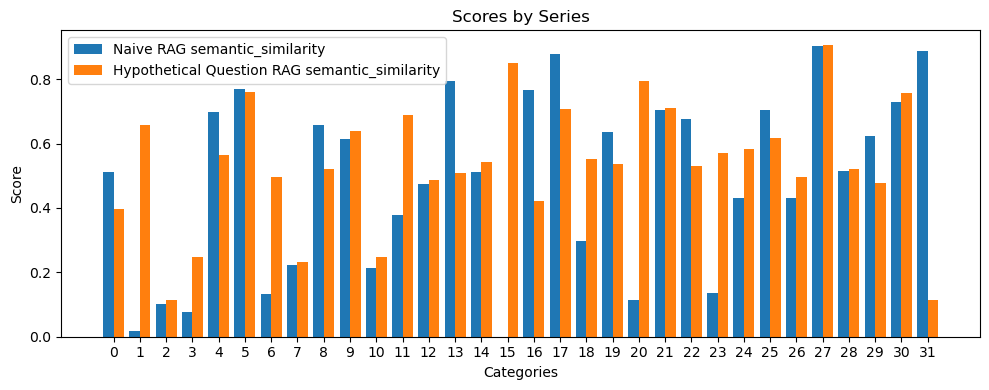

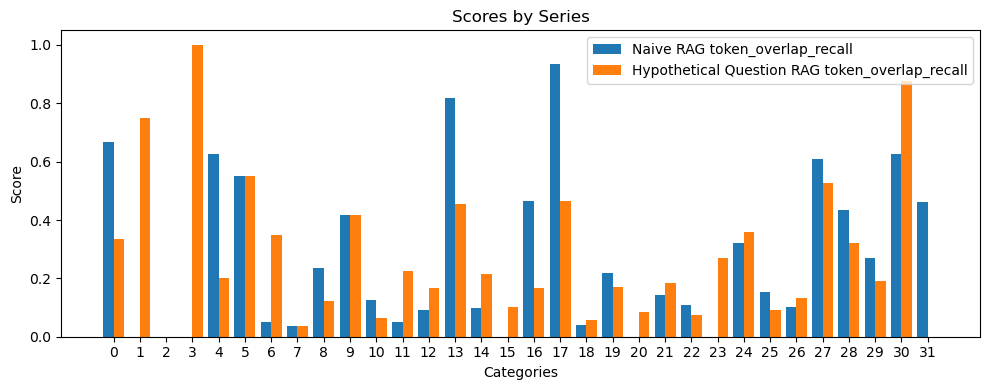

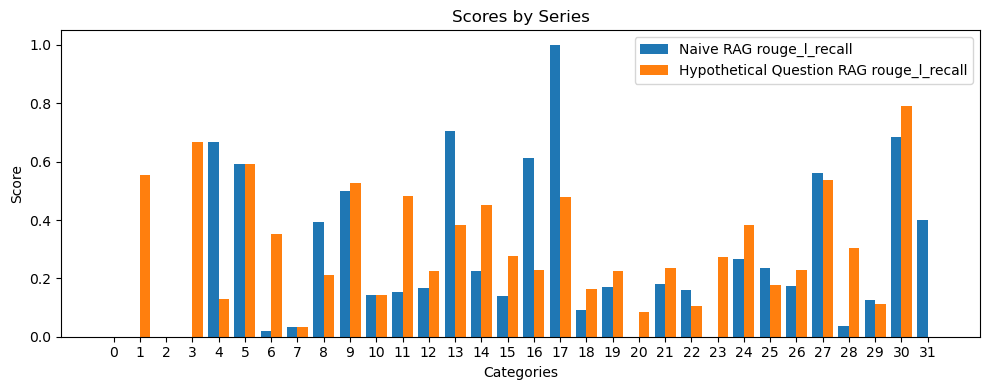

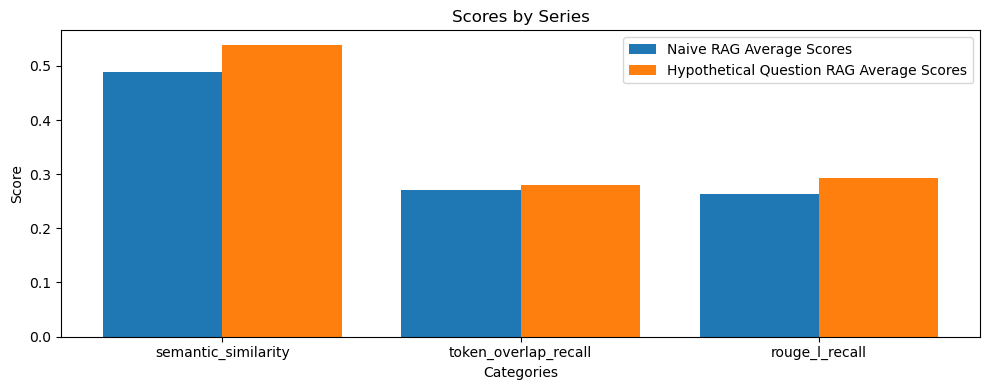

In [35]:
file_path = '../lab-data/hypothetical_question_rag_result.csv'
df = pd.read_csv(file_path)
metrics = df.columns[-3:]

# Prepare the data
hypothetical_question_series_names = [f"Hypothetical Question RAG {name}" for name in metrics.tolist()]
hypothetical_question_series_data = [df[metric].tolist() for metric in metrics]

# Plot individual series bar charts
for i in range(3):
    plot_barchart(
        [series_names[i], hypothetical_question_series_names[i]],
        [series_data[i], hypothetical_question_series_data[i]],
        list(range(len(series_data[i])))
    )

# Calculate the average for each metric
hypothetical_question_average_scores = [sum(data) / len(data) for data in hypothetical_question_series_data]

# Plot the average scores bar chart
plot_barchart(['Naive RAG Average Scores', 'Hypothetical Question RAG Average Scores'], [average_scores, hypothetical_question_average_scores], metrics.tolist())

#### Query Decomposition
Purpose: Handle complex queries by breaking them down into simpler sub-queries, each targeting a specific aspect of the original question.

Implementation: A complex query is decomposed into multiple, more manageable sub-queries. Each sub-query is processed independently through the retrieval system, and the results are combined before being passed to the language model.

Outcome: This technique helps in better addressing multifaceted queries by ensuring that all relevant aspects are covered in the final response.

In [36]:
def decompose_question(question):
    prompt = f"""
<s>[INST] <<SYS>>
Given the following complex query, analyze whether it requires decomposition into simpler subqueries. If the query is already straightforward and can be answered directly, do not decompose it. If the query is complex or involves multiple steps, break it down into a sequence of subqueries that can be addressed individually. Each subquestion in a line.
<</SYS>>
<question>
{question}
</question>
[/INST]
<sub_questions>
"""
    cleaned_response = re.sub(r'</?[^>]+>|\[/?(INST|SYS)\]', '', generate(prompt))
    return [question for question in cleaned_response.split('\n') if len(question) > 10][:4]

sub_questions = decompose_question("""Does one party have the right to terminate or is consent or notice required of the counterparty if such party undergoes a change of control, such as a merger, stock sale, transfer of all or substantially all of its assets or business, or assignment by operation of law?""")

print(sub_questions)

['Does the agreement specify the circumstances under which a party may terminate the agreement?', 'Does the agreement specify the notice period required for termination?', 'Does the agreement specify the procedures for handling a change of control, such as obtaining consent or providing notice?', 'Does the agreement specify the consequences of a change of control, such as the continuation or termination of the agreement?']


In [37]:
db.drop_table("NaiveRAG")
db.create_table(
  table_name="NaiveRAG",
  table_fields=[
    {"name": "ID", "dataType": "INT", "primaryKey": True},
    {"name": "Doc", "dataType": "STRING"},
    {"name": "Embedding", "dataType": "VECTOR_FLOAT", "dimensions": 512}
  ]
)

(200, {'statusCode': 200, 'message': 'Create NaiveRAG successfully.'})

In [ ]:
records = [
    {
        "ID": index,
        "Doc": text,
        "Embedding": embed_text(text)
    }
    for index, text in enumerate(chunks)
]
records[:2]

In [39]:
db.insert("NaiveRAG", records)

(200,
 {'message': 'Insert data to NaiveRAG successfully.',
  'result': {'inserted': 107, 'skipped': 0},
  'statusCode': 200})

In [ ]:
def basic_retriever(table_name, question, top_k):
    code, resp = db.query(
        table_name=table_name,
        query_field="Embedding",
        query_vector=embed_text(question),
        limit=top_k
    )
    return resp["result"]
basic_retriever("NaiveRAG", "What's the agreement date?", 5)

In [41]:
def naive_rag(table_name, question):
    docs = basic_retriever(table_name, question, 5)
    docs_str = "------------------------\n"
    for doc in docs:
        docs_str += doc["Doc"] + "\n------------------------\n"
    prompt = f"""
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.

Your answer should be grounded by the information provided in the documents below.
Don't make up answers.
Don't explain your thought process.
Directly answer the question in concise way.

<documents>
{docs_str}
</documents>
<</SYS>>
[/INST]
<question>
{question}
</question>
"""
    cleaned_response = re.sub(r'</?[^>]+>|\[/?(INST|SYS)\]', '', generate(prompt))
    return prompt, cleaned_response

data_augmented_prompt, answer = naive_rag("NaiveRAG", "What's the agreement date?")

answer

'\nThe agreement date is November 6, 2016.\n\n\nThe agreement date is November 6, 2016.\n\n\nThe agreement date is November 6, 2016.\n\n\nThe agreement date is November 6, 2016.\n\n\nThe agreement date is November 6, 2016.\n\n\nThe agreement date is November 6, 2016.\n\n\nThe agreement date is November 6, 2016.\n\n<solution'

In [42]:
def sub_question_resolver(sub_questions):
    question_answer = ""
    for sub_question in sub_questions:
        data_augmented_prompt, answer = naive_rag("NaiveRAG", sub_question)
        question_answer += f"Sub-Question: {sub_question}\nAnswer: {answer}\n------------------------\n"
    return question_answer
sub_question_resolver(decompose_question("Does one party have the right to terminate or is consent or notice required of the counterparty if such party undergoes a change of control, such as a merger, stock sale, transfer of all or substantially all of its assets or business, or assignment by operation of law?"))

'Sub-Question: Does the agreement specify the circumstances under which a party may terminate the agreement?\nAnswer: \nYes, the agreement specifies the circumstances under which a party may terminate the agreement. According to Section 15.2, either party may terminate the agreement if the other party materially breaches a material provision of the agreement and fails to cure such breach within thirty (30) days, or if the other party undergoes an Insolvency Event. Additionally, the agreement outlines specific termination rights for ENERGOUS and DIALOG, including termination upon written notice in the event of a Change of Control, failure to achieve a design-win pipeline, or failure to achieve certain sales targets. \n```\n\n------------------------\nSub-Question: Does the agreement specify the notice period required for termination?\nAnswer: \nYes, the agreement specifies the notice period required for termination. According to Section 15.1, either party may terminate this Agreement wi

In [43]:
def sub_query_rag(question):
    sub_questions_qa = sub_question_resolver(decompose_question(question))
    prompt = f"""
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.

Your answer should be grounded by the information provided in the groud_truth section below.
Don't make up answers.
Don't explain your thought process.
Directly answer the question in concise way.

<groud_truth>
{sub_questions_qa}
</groud_truth>
<</SYS>>
[/INST]
<question>
{question}
</question>
<answer>
"""
    cleaned_response = re.sub(r'</?[^>]+>|\[/?(INST|SYS)\]', '', generate(prompt))
    return prompt, cleaned_response

data_augmented_prompt, answer = sub_query_rag("Does one party have the right to terminate or is consent or notice required of the counterparty if such party undergoes a change of control, such as a merger, stock sale, transfer of all or substantially all of its assets or business, or assignment by operation of law?")

data_augmented_prompt, answer

("\n<s>[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n\nYour answer should be grounded by the information provided in the groud_truth section below.\nDon't make up answers.\nDon't explain your thought process.\nDirectly answer the question in concise way.\n\n<groud_truth>\nSub-Question: Does the agreement specify the circumstances under which a party may terminate the agreement?\nAnswer: \nYes, the agreement specifies the circumstances under which a party may terminate the agreement. According to Section 15.2, eit

In [44]:
# Load the CSV file
file_path = '../lab-data/ENERGOUSCORP_qa.csv'
df = pd.read_csv(file_path)

# Assuming the CSV has 'Question' and 'Answer' columns
questions = df['question'].tolist()
answers = df['answer'].tolist()

questions, answers

(['What is The name of the contract?',
  'What is The two or more parties who signed the contract?',
  'What is The date of the contract?',
  'What is The date when the contract is effective?',
  "On what date will the contract's initial term expire?",
  'What is the renewal term after the initial term expires? This includes automatic extensions and unilateral extensions with prior notice.',
  'What is the notice period required to terminate renewal?',
  "Which state/country's law governs the interpretation of the contract?",
  'Is there a restriction on the ability of a party to compete with the counterparty or operate in a certain geography or business or technology sector?',
  'Is there an exclusive dealing\xa0 commitment with the counterparty? This includes a commitment to procure all “requirements” from one party of certain technology, goods, or services or a prohibition on licensing or selling technology, goods or services to third parties, or a prohibition on\xa0 collaborating o

In [45]:
data_augmented_prompts = []
generated_answers = []
for index in tqdm(range(len(questions)), desc="Answering questions"):
    question = questions[index]
    data_augmented_prompt, generated_answer = sub_query_rag(question)
    data_augmented_prompts.append(data_augmented_prompt)
    generated_answers.append(generated_answer)

generated_answers

Answering questions: 100%|██████████| 32/32 [04:35<00:00,  8.62s/it]


['The name of the contract is the "Strategic Alliance Agreement".\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n</',
 'The parties that signed the contract are not explicitly mentioned in the provided documents. However, it can be inferred that the parties are DIALOG and its affiliates on one side, and the other party (referred to as "the other party" or "the party against which enforcement is sought") on the other side. The identity of the other party is not specified in the provided documents.\n\n\n\n\n\n\n\n\n\n\n\n\n',
 'The date of the contract is November 6, 2016, as stated in the "EXECUTION VERSION" section of the contract.\n\n                               [/',
 " >\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and posi

In [46]:
evaluation_results = []
for i in range(len(questions)):
    print(i,end='|')
    ground_truth_embedding = embed_text(answers[i])
    answer_embedding = embed_text(generated_answers[i])
    cosine_similarity = util.cos_sim(ground_truth_embedding, answer_embedding)[0][0].item()
    
    datum = {
        "answer": generated_answers[i],
        "ground_truth_answers": [
            answers[i]
        ]
    }
    metric = DeterministicAnswerCorrectness()
    eval_result = metric(**datum)
    evaluation_results.append({
        "question": data_augmented_prompts[i],
        "ref_answer": answers[i],
        "response": generated_answers[i],
        "semantic_similarity": cosine_similarity,
        "token_overlap_recall": eval_result["token_overlap_recall"],
        "rouge_l_recall": eval_result["rouge_l_recall"]
    })

evaluation_results

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|

[{'question': '\n<s>[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don\'t know the answer to a question, please don\'t share false information.\n\nYour answer should be grounded by the information provided in the groud_truth section below.\nDon\'t make up answers.\nDon\'t explain your thought process.\nDirectly answer the question in concise way.\n\n<groud_truth>\nSub-Question: What is the name of the contract?\nAnswer: \nThe name of the contract is the "Strategic Alliance Agreement".\n\n\nThe name of the contract is the "Strategic Alliance Agreement".\n\n\nThe name of the contract is the

In [47]:
import csv

# Specify the file name
csv_file = '../lab-data/query_decomposition_rag_result.csv'

# Write the data to a CSV file
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=evaluation_results[0].keys())
    writer.writeheader()
    writer.writerows(evaluation_results)

csv_file

'../lab-data/query_decomposition_rag_result.csv'

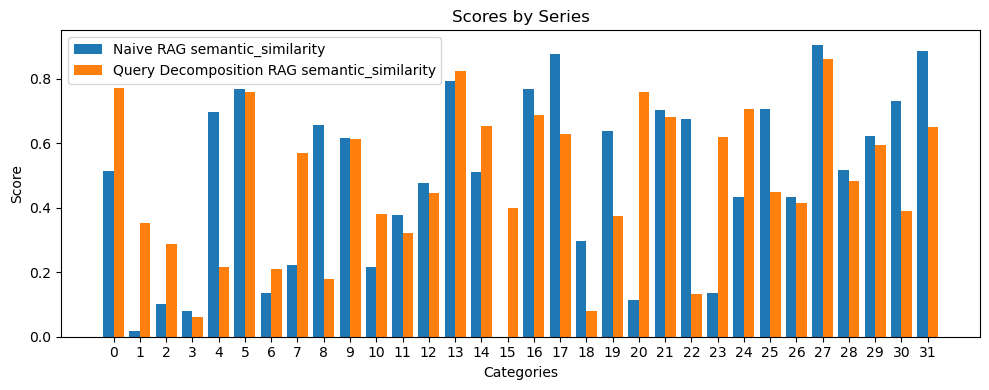

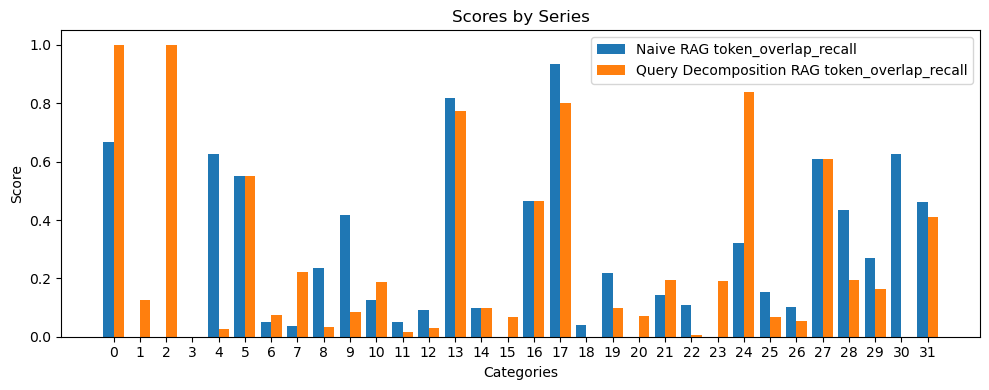

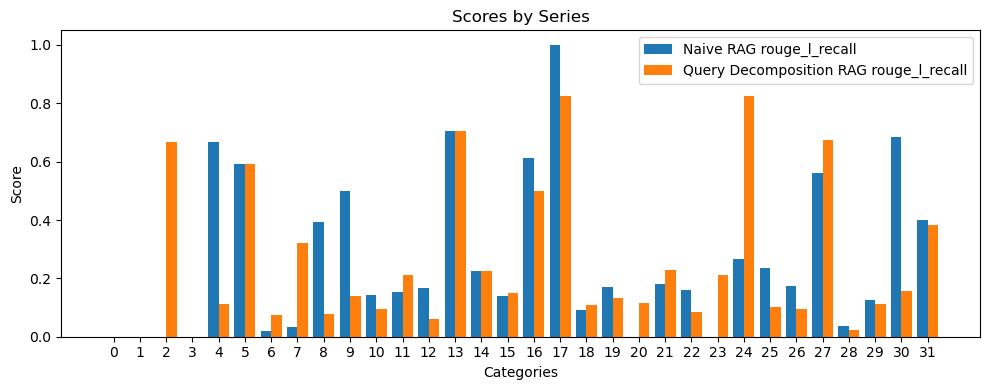

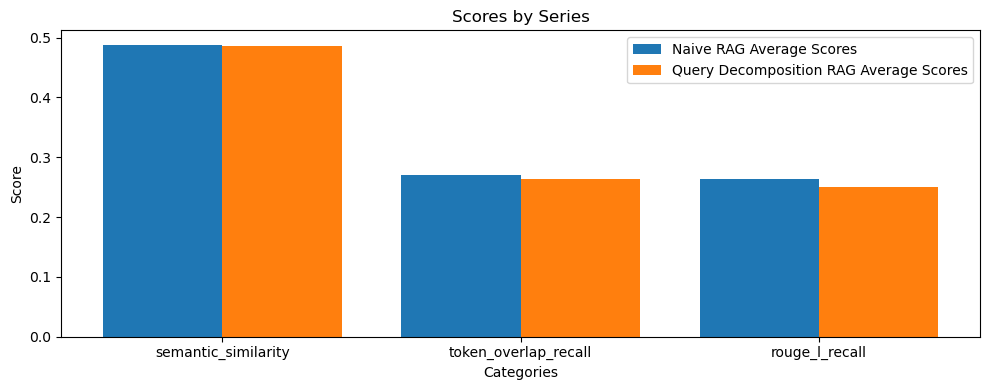

In [48]:
file_path = '../lab-data/query_decomposition_rag_result.csv'
df = pd.read_csv(file_path)
metrics = df.columns[-3:]

# Prepare the data
query_decomposition_series_names = [f"Query Decomposition RAG {name}" for name in metrics.tolist()]
query_decomposition_series_data = [df[metric].tolist() for metric in metrics]

# Plot individual series bar charts
for i in range(3):
    plot_barchart(
        [series_names[i], query_decomposition_series_names[i]],
        [series_data[i], query_decomposition_series_data[i]],
        list(range(len(series_data[i])))
    )

# Calculate the average for each metric
query_decomposition_average_scores = [sum(data) / len(data) for data in query_decomposition_series_data]

# Plot the average scores bar chart
plot_barchart(['Naive RAG Average Scores', 'Query Decomposition RAG Average Scores'], [average_scores, query_decomposition_average_scores], metrics.tolist())

#### Query Decomposition + Hypothetical Questions
Purpose: Combine the strengths of both Hypothetical Question Generation and Query Decomposition for handling complex queries with targeted specificity.

Implementation: The query is first decomposed into sub-queries, and each sub-query is then using the Hypothetical Question pipeline to get the answer. This hybrid approach aims to maximize the relevance and coverage of the retrieved content.

Outcome: This method provides the most comprehensive and contextually enriched responses, particularly for complex queries, by ensuring both broad coverage and targeted retrieval.

In [49]:
def sub_question_resolver_hypothetical_question(sub_questions):
    question_answer = ""
    for sub_question in sub_questions:
        data_augmented_prompt, answer = hypothetical_question_rag("HypotheticalQuestions", sub_question)
        question_answer += f"Sub-Question: {sub_question}\nAnswer: {answer}\n------------------------\n"
    return question_answer
sub_question_resolver_hypothetical_question(decompose_question("Does one party have the right to terminate or is consent or notice required of the counterparty if such party undergoes a change of control, such as a merger, stock sale, transfer of all or substantially all of its assets or business, or assignment by operation of law?"))

'Sub-Question: Does the agreement specify the circumstances under which a party may terminate the agreement?\nAnswer: Yes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\nYes\n\n------------------------\nSub-Question: Does the agreement specify the notice period required for termination?\nAnswer: Yes, the agreement specifies the notice period required for termination. According to Section 15.1, the agreement will automatically renew for one or more annual periods after the initial term of seven years, unless either party gives notice of non-renewal at least one hundred eighty (180) days prior to the beginning of any Renewal Term. Additionally, Section 15.2(a) states that either party may terminate this Agreement (or, in the event this Agreement has been previously terminated, the Wind Down Period, if any) immediately upon the issuance of written notice to the other party in the event that the other party materially breaches\n--------------

In [50]:
def sub_query_rag_with_hypothetical_question(question):
    ids, docs = hypothetical_question_retriever("HypotheticalQuestions", question, 15)
    docs_str = "------------------------\n"
    for doc in docs:
        docs_str += doc + "\n------------------------\n"
    sub_questions_qa = sub_question_resolver_hypothetical_question(decompose_question(question))
    prompt = f"""
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.

Your answer should be grounded by the information provided in the documents and groud_truth section below.
Don't make up answers.
Don't explain your thought process.
Directly answer the question in concise way.

<documents>
{docs_str}
</documents>

<groud_truth>
{sub_questions_qa}
</groud_truth>
<</SYS>>
[/INST]
<question>
{question}
</question>
<answer>
"""
    cleaned_response = re.sub(r'</?[^>]+>|\[/?(INST|SYS)\]', '', generate(prompt))
    return prompt, cleaned_response

data_augmented_prompt, answer = sub_query_rag_with_hypothetical_question("What's the agreement date?")

data_augmented_prompt, answer

('\n<s>[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don\'t know the answer to a question, please don\'t share false information.\n\nYour answer should be grounded by the information provided in the documents and groud_truth section below.\nDon\'t make up answers.\nDon\'t explain your thought process.\nDirectly answer the question in concise way.\n\n<documents>\n------------------------\n of a\ngovernment, political party or instrumentality to assist it in obtaining or retaining business, including the U.S. Foreign Corrupt Practices Act or any\ncomparable legislation in another country.\

In [51]:
# Load the CSV file
file_path = '../lab-data/ENERGOUSCORP_qa.csv'
df = pd.read_csv(file_path)

# Assuming the CSV has 'Question' and 'Answer' columns
questions = df['question'].tolist()
answers = df['answer'].tolist()

questions, answers

(['What is The name of the contract?',
  'What is The two or more parties who signed the contract?',
  'What is The date of the contract?',
  'What is The date when the contract is effective?',
  "On what date will the contract's initial term expire?",
  'What is the renewal term after the initial term expires? This includes automatic extensions and unilateral extensions with prior notice.',
  'What is the notice period required to terminate renewal?',
  "Which state/country's law governs the interpretation of the contract?",
  'Is there a restriction on the ability of a party to compete with the counterparty or operate in a certain geography or business or technology sector?',
  'Is there an exclusive dealing\xa0 commitment with the counterparty? This includes a commitment to procure all “requirements” from one party of certain technology, goods, or services or a prohibition on licensing or selling technology, goods or services to third parties, or a prohibition on\xa0 collaborating o

In [52]:
data_augmented_prompts = []
generated_answers = []
for index in tqdm(range(len(questions)), desc="Answering questions"):
    question = questions[index]
    data_augmented_prompt, generated_answer = sub_query_rag_with_hypothetical_question(question)
    data_augmented_prompts.append(data_augmented_prompt)
    generated_answers.append(generated_answer)

generated_answers

Answering questions: 100%|██████████| 32/32 [04:50<00:00,  9.07s/it]


['ENRGUS-DIALOG Agreement\n\n                                      [/',
 'Dialog Semiconductor (UK) Ltd. and Energous Corporation.\n\n',
 'The date of the contract is November 6, 2016.\n\n\nThe date of the contract is mentioned in the first paragraph of the contract, which states that the contract is made and entered into as of November 6, 2016.\n\n\nDirect Answer\n\n\nHigh\n\n\nHigh\n\n\nHigh\n\n\nHigh\n\n\nHigh\n\n<solution_com',
 'November 6, 2016\n\n\nThe date when the contract is effective is explicitly mentioned in the documents as "November 6, 2016".\n\n\n\n  [/s]   [/s]   [/s]   [/s]   [/s]   [/s]   [/s]   [/s]   [/',
 "The contract's initial term is seven (7) years, and it will automatically renew for one or more annual periods after the initial term unless either party gives notice of non-renewal at least one hundred eighty (180) days prior to the beginning of any Renewal Term. Therefore, the initial term will expire on the date that is seven years from the Effective Date, wh

In [53]:
evaluation_results = []
for i in range(len(questions)):
    print(i,end='|')
    ground_truth_embedding = embed_text(answers[i])
    answer_embedding = embed_text(generated_answers[i])
    cosine_similarity = util.cos_sim(ground_truth_embedding, answer_embedding)[0][0].item()
    
    datum = {
        "answer": generated_answers[i],
        "ground_truth_answers": [
            answers[i]
        ]
    }
    metric = DeterministicAnswerCorrectness()
    eval_result = metric(**datum)
    evaluation_results.append({
        "question": data_augmented_prompts[i],
        "ref_answer": answers[i],
        "response": generated_answers[i],
        "semantic_similarity": cosine_similarity,
        "token_overlap_recall": eval_result["token_overlap_recall"],
        "rouge_l_recall": eval_result["rouge_l_recall"]
    })

evaluation_results

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|

[{'question': "\n<s>[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n\nYour answer should be grounded by the information provided in the documents and groud_truth section below.\nDon't make up answers.\nDon't explain your thought process.\nDirectly answer the question in concise way.\n\n<documents>\n------------------------\n of voting securities, by contract or otherwise.\n \n1.2  “Approved Production Specifications” means those materials, processes and workmanship specifications of Manufacturing\nSubcontractors as

In [54]:
# Specify the file name
csv_file = '../lab-data/advanced_rag_result.csv'

# Write the data to a CSV file
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=evaluation_results[0].keys())
    writer.writeheader()
    writer.writerows(evaluation_results)

csv_file

'../lab-data/advanced_rag_result.csv'

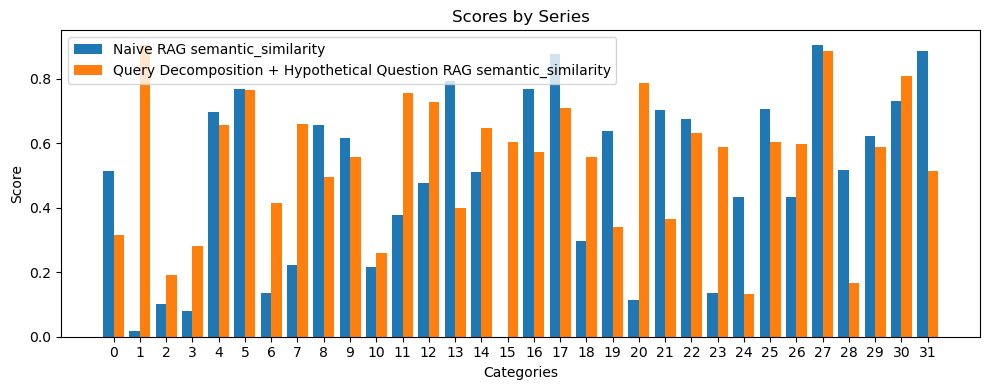

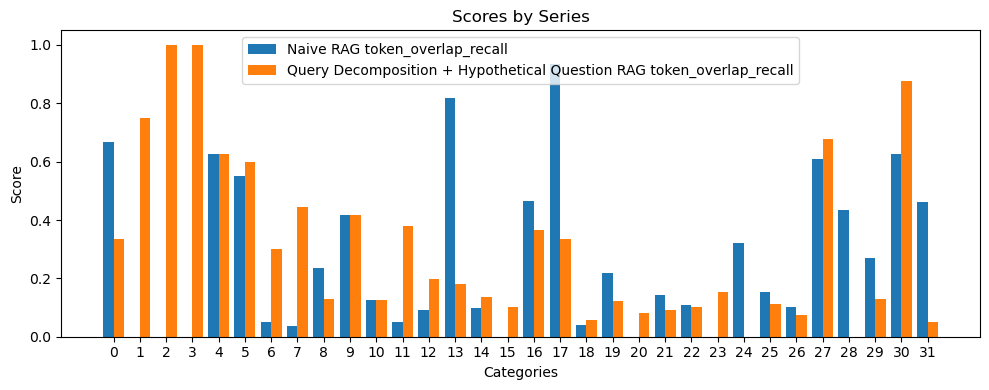

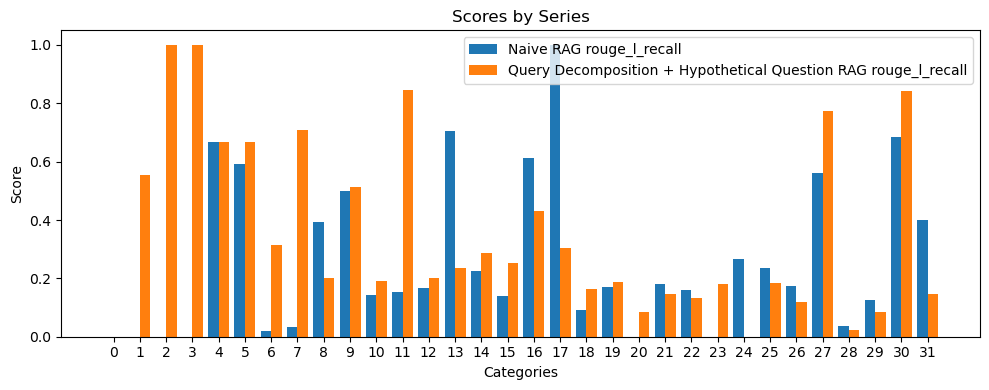

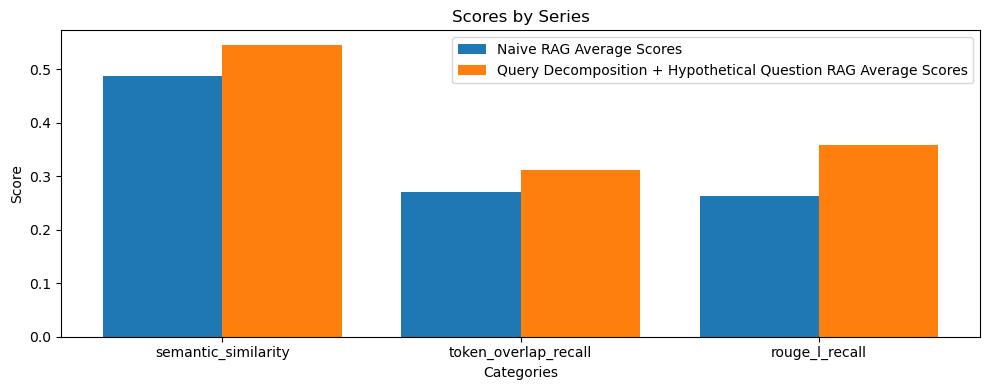

In [55]:
file_path = '../lab-data/advanced_rag_result.csv'
df = pd.read_csv(file_path)
metrics = df.columns[-3:]

# Prepare the data
qd_and_hq_series_names = [f"Query Decomposition + Hypothetical Question RAG {name}" for name in metrics.tolist()]
qd_and_hq_series_data = [df[metric].tolist() for metric in metrics]

# Plot individual series bar charts
for i in range(3):
    plot_barchart(
        [series_names[i], qd_and_hq_series_names[i]],
        [series_data[i], qd_and_hq_series_data[i]],
        list(range(len(series_data[i])))
    )

# Calculate the average for each metric
qd_and_hq_average_scores = [sum(data) / len(data) for data in qd_and_hq_series_data]

# Plot the average scores bar chart
plot_barchart(['Naive RAG Average Scores', 'Query Decomposition + Hypothetical Question RAG Average Scores'], [average_scores, qd_and_hq_average_scores], metrics.tolist())